In [1]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

%matplotlib inline
import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../")
import setigen

# # 200
# i = 200
# fn = '/datax/users/bryanb/data/split_files/4194304_%04d.fil' % i
# fil = Waterfall(fn)

/Users/bbrzycki/anaconda3/envs/breakthroughlisten27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
setigen

<module 'setigen' from '../setigen/__init__.pyc'>

In [3]:
tsamp = 18.253611008
fch1 = 6095.214842353016
df = -2.7939677238464355e-06

fchans = 1024
tchans = 16

In [32]:
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

In [5]:
fs, ts

(array([6095.21484235, 6095.21483956, 6095.21483677, ..., 6095.21198971,
        6095.21198692, 6095.21198412]),
 array([  0.        ,  18.25361101,  36.50722202,  54.76083302,
         73.01444403,  91.26805504, 109.52166605, 127.77527706,
        146.02888806, 164.28249907, 182.53611008, 200.78972109,
        219.0433321 , 237.2969431 , 255.55055411, 273.80416512]))

In [6]:
data = np.zeros((ts.size, fs.size))

In [7]:
data[0].size

1024

In [8]:
def freq(time, f_start, drift_rate):
    """
    Calculates central frequency as a function of time, for linear frequency drift
    
    Args:
        time, NumPy array of timestamps
        f_start, starting frequency of signal
        drift_rate, slope of drift (make sure you use proper units)
    
    """
    return f_start + drift_rate * time

In [9]:
signal = freq(ts, fs[400], -0.000005)
signal

array([6095.21372477, 6095.2136335 , 6095.21354223, 6095.21345096,
       6095.21335969, 6095.21326843, 6095.21317716, 6095.21308589,
       6095.21299462, 6095.21290335, 6095.21281209, 6095.21272082,
       6095.21262955, 6095.21253828, 6095.21244701, 6095.21235575])

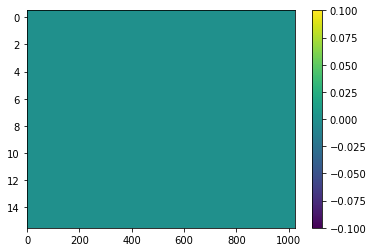

In [10]:
plt.imshow(data, aspect='auto')
plt.colorbar()

In [ ]:
for j in np.arange(ts.size):
    for i in np.arange(fs.size):
        

In [11]:
tt, ff = np.meshgrid(ts, fs)

In [13]:
tt, ff

(array([[  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        ...,
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512]]),
 array([[6095.21484235, 6095.21484235, 6095.21484235, ..., 6095.21484235,
         6095.21484235, 6095.21484235],
        [6095.21483956, 6095.21483956, 6095.21483956, ..., 6095.21483956,
         6095.21483956, 6095.21483956],
        [6095.21483677, 6095.21483677, 6095.21483677, ..., 6095.21483677,
         6095.21483677, 6095.214836

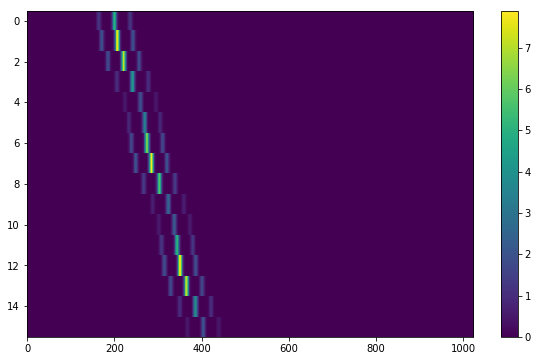

In [174]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

###

def constant_curve(f_start, drift_rate):
    def curve(t):
        return f_start + drift_rate * t
    return curve

def squared_curve(f_start, drift_rate):
    def curve(t):
        return f_start + drift_rate * t**2
    return curve

def sine_curve(f_start, drift_rate, period, amplitude):
    def curve(t):
        return f_start + amplitude * np.sin(2*np.pi*t/period) + drift_rate * t
    return curve

###

def box_shape(width = 0.00001):
    def shape(f, f_center):
        return (np.abs(f-f_center) < width).astype(int)
    return shape

def gaussian_shape(width = 0.00001):
    def shape(f, f_center):
        return gaussian(f, f_center, width)
    return shape

def multiple_gaussian_shape(width = 0.00001):
    def shape(f, f_center):
        return gaussian(f, f_center - 0.0001, width)/4 \
            + gaussian(f, f_center, width) \
            + gaussian(f, f_center + 0.0001, width)/4
    return shape

###

def constant_intensity(level=1):
    def intensity(t):
        return level
    return intensity

def sine_intensity(period, amplitude=1, level=1):
    def intensity(t):
        return amplitude * np.sin(2*np.pi*t/period) + level
    return intensity

###

def render(t, 
           f,
           curve, 
           shape, 
           intensity):
    return intensity(t) * shape(f, curve(t))
    
test = render(tt, 
              ff, 
              sine_curve(f_start = fs[200], drift_rate = -0.000002,
                         period = 100, amplitude = 0.00002), 
              multiple_gaussian_shape(width = 0.00001), 
              sine_intensity(period = 100, amplitude = 3, level = 5))
plt.figure(figsize=(10,6))
plt.imshow(test, aspect='auto')
plt.colorbar()

In [175]:
tt

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 18.25361101,  18.25361101,  18.25361101, ...,  18.25361101,
         18.25361101,  18.25361101],
       [ 36.50722202,  36.50722202,  36.50722202, ...,  36.50722202,
         36.50722202,  36.50722202],
       ...,
       [237.2969431 , 237.2969431 , 237.2969431 , ..., 237.2969431 ,
        237.2969431 , 237.2969431 ],
       [255.55055411, 255.55055411, 255.55055411, ..., 255.55055411,
        255.55055411, 255.55055411],
       [273.80416512, 273.80416512, 273.80416512, ..., 273.80416512,
        273.80416512, 273.80416512]])

In [107]:
sine_intensity(ts, 1)

array([1.        , 1.99974262, 0.95463831, 0.00231559, 1.09063   ,
       1.99357222, 0.86428828, 0.01258548, 1.18051405, 1.97922399,
       0.77505526, 0.03098251, 1.26891233, 1.95681603, 0.6876737 ,
       0.05735527])

In [125]:
def f(a):
    return 2*a

def x(b):
    def f(a):
        return 2*a + b
    return f

In [129]:
x(3)(-1)

1